## Bibliotecas

In [266]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report, precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef, precision_recall_curve, auc
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd 

## Leitura da Base de dados 


In [267]:
df_engagement = pd.read_csv('Student-Performance-and-Engagement-Prediction-eLearning-datasets\StudentEngagementLevelPrediction-BinaryCase\Student Engagement Level-Binary.csv')

df_performance = pd.read_csv('Student-Performance-and-Engagement-Prediction-eLearning-datasets\StudentPerformancePrediction-BinaryScenario\Student Performance Prediction-Binary.csv')

## Breve explicação sobre as variáveis usadas no modelo

O conjunto de dados coletado é de um curso de graduação de segundo ano em ciências oferecido em uma universidade norte-americana.

|Feature|	Engagement Metric Type| Description|	Type |	Value/s |
|:--- |:--- |:--- |:--- |:---|
|Student Id|	|	Student identifier|	Nominal|	std000, …, std485|
|Number of Logins|	Interaction|	Number of times student accessed the course site on the LMS|	Numeric|	0, …, 647|
|Number of Content Reads|	Interaction|	Number of times student accessed course material|	Numeric|	0, …, 1007| 
|Number of Forum Reads|	Interaction |	Number of times student read posts on the discussion forum|	Numeric|	0, …, 58|
|Number of Forum Posts|	Interaction|	Number of times student posted on the discussion forum|	Numeric|	0, …, 6|
|Number of Quiz Reviews|	Interaction|	Number of times student reviewed their quiz solution before final submission|	Numeric|	0, …, 12|
|Assignment 1 lateness indicator|	Effort| A binary indicator stating whether Assignment 1 submission is late or not|	Numeric|	0,1|
|Assignment 2 lateness indicator|	Effort|	A binary indicator stating whether Assignment 2 submission is late or not|	Numeric|	0,1|
|Assignment 3 lateness indicator|	Effort|	A binary indicator stating whether Assignment 3 submission is late or not|	Numeric|	0,1|
|Assignment 1 duration to submit (in hours)|	Effort|	The duration (in hours) between Assignment 1 posting and submission|	Numeric|	0, …, 583|
|Assignment 2 duration to submit (in hours)|	Effort|	The duration (in hours) between Assignment 2 posting and submission|	Numeric|	0, …, 297|
|Assignment 3 duration to submit (in hours)|	Effort|	The duration (in hours) between Assignment 3 posting and submission|	Numeric|	0, …, 632|
|Average Assignment duration to submit (in hours)|	Effort|	The average duration (in hours) between Assignments’ posting and submission|	Numeric|	0, …, 496|
|Engagement Level| | Student engagement level |	Nominal|	L, H|
|Student Category|	|	Class|	Binary|	1,0|


A nota final (Class) foi classificada em duas categorias:

-	Bom (1) - o aluno vai terminar o curso com uma boa nota (60-100)

-	Fraco (0) - o aluno terminará o curso com nota fraca (≤ 59). Esse limite foi escolhido porque a nota típica de aprovação para o curso de graduação costuma ser 60 na maioria das universidades.

## Pre-processamento  

In [268]:
#Mergiando dataframes para obter a coluna target

df_merge = pd.merge(df_engagement,
                  df_performance[['Class','Student ID']],
                  on='Student ID')

df_merge['Class'].replace({"G": "1", "W": "0"}, inplace=True)

## Renomeando colunas para melhor vizualização
Colunas = ['id', 'logins', 'content_reads', 'forum_reads', 'forum_posts', 'reviews_before_submission', 
          'assignment_1_lateness_indicator', 'assignment_2_lateness_indicator', 'assignment_3_lateness_indicator', 
           'assignment_1_duration_submit', 'assignment_2_duration_submit', 'assignment_3_duration_submit', 
           'average_time_submit_assignment', 'engagement_level', 'class']

df_merge.columns = Colunas

# Id não vai ser necessario para estudo
df_completed = df_merge.drop(['id'], axis=1)

# Class deve ser valor inteiro
df_completed['class'] = df_completed['class'].astype(int)

#Aplicando One-Hot-Encoder na colunas engagement_level
categoricas = ['engagement_level']

df_completed = pd.get_dummies(df_completed, prefix = categoricas)

df_completed.head()

,logins,content_reads,forum_reads,forum_posts,reviews_before_submission,assignment_1_lateness_indicator,assignment_2_lateness_indicator,assignment_3_lateness_indicator,assignment_1_duration_submit,assignment_2_duration_submit,assignment_3_duration_submit,average_time_submit_assignment,class,engagement_level_H,engagement_level_L
0,143,344,58,0,3,0,0,0,178.166667,92.716667,116.166667,129.016667,1,1,0
1,70,342,0,0,4,0,0,0,294.033333,196.083333,217.750000,235.955556,1,0,1
2,42,219,0,0,3,0,0,0,169.600000,235.733333,260.333333,221.888889,1,0,1
3,92,271,2,0,6,0,0,0,341.150000,245.900000,271.216667,286.088889,1,0,1
4,116,379,0,0,1,0,0,0,325.500000,236.283333,260.733333,274.172222,1,0,1


In [271]:
#Ultimas verificações nas Variáveis 

df_completed.info()

#df_completed.to_csv('data.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486 entries, 0 to 485
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   logins                           486 non-null    int64  
 1   content_reads                    486 non-null    int64  
 2   forum_reads                      486 non-null    int64  
 3   forum_posts                      486 non-null    int64  
 4   reviews_before_submission        486 non-null    int64  
 5   assignment_1_lateness_indicator  486 non-null    int64  
 6   assignment_2_lateness_indicator  486 non-null    int64  
 7   assignment_3_lateness_indicator  486 non-null    int64  
 8   assignment_1_duration_submit     486 non-null    float64
 9   assignment_2_duration_submit     486 non-null    float64
 10  assignment_3_duration_submit     486 non-null    float64
 11  average_time_submit_assignment   486 non-null    float64
 12  class                 

## Divisão entre treino e teste 

In [247]:
X_train, X_test, y_train, y_test = train_test_split(df_completed.drop(['class'], axis=1), 
                                                    df_completed['class'], 
                                                    test_size=0.33, 
                                                    random_state=42)

# Wrapper 

## Forward selection


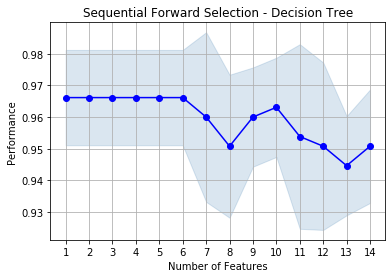

In [248]:
sfs_dt = SFS(DecisionTreeClassifier(random_state=42),
          k_features=14,
          forward=True,
          scoring = 'accuracy')

sfs_dt.fit(X_train, y_train)

fig1 = plot_sfs(sfs_dt.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection - Decision Tree')
plt.grid()
plt.show()

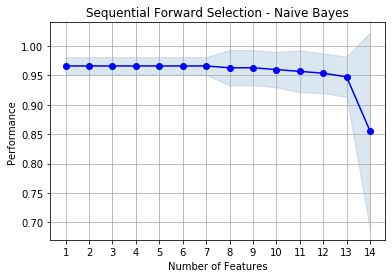

In [249]:
sfs_gb = SFS(GaussianNB(),
          k_features=14, 
          forward=True,
          scoring = 'accuracy')

sfs_gb.fit(X_train, y_train)

fig1 = plot_sfs(sfs_gb.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection - Naive Bayes')
plt.grid()
plt.show()

## Backward elimination

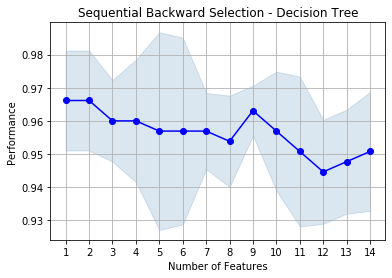

In [250]:
sbs_dt = SFS(DecisionTreeClassifier(random_state=42),
          k_features=(1,14),
          forward=False,
          scoring = 'accuracy')

sbs_dt.fit(X_train, y_train)

fig1 = plot_sfs(sbs_dt.get_metric_dict(), kind='std_dev')
plt.title('Sequential Backward Selection - Decision Tree')
plt.grid()
plt.show()

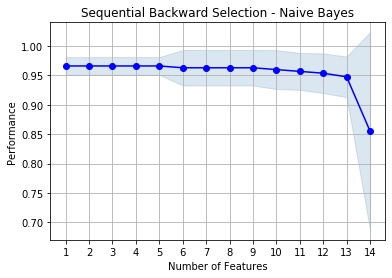

In [251]:
sbs_gb = SFS(GaussianNB(),
          k_features=(1,14), 
          forward=False,
          scoring = 'accuracy')

sbs_gb.fit(X_train, y_train)

fig1 = plot_sfs(sbs_gb.get_metric_dict(), kind='std_dev')
plt.title('Sequential Backward Selection - Naive Bayes')
plt.grid()
plt.show()

## bi-directional elimination

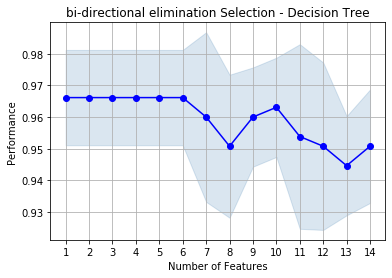

In [252]:
sfs_bi_dt = SFS(DecisionTreeClassifier(random_state=42),
                k_features=(1,14),
                forward=True,
                floating=True,
                scoring = 'accuracy')

sfs_bi_dt.fit(X_train, y_train)

fig1 = plot_sfs(sfs_bi_dt.get_metric_dict(), kind='std_dev')
plt.title('bi-directional elimination Selection - Decision Tree')
plt.grid()
plt.show()

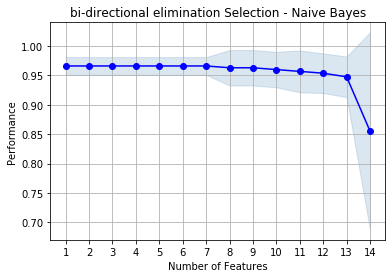

In [253]:
ssfs_bi_gb = SFS(GaussianNB(),
                 k_features=(1,14),
                 forward=True,
                 floating=True,
                 scoring = 'accuracy')

ssfs_bi_gb.fit(X_train, y_train)

fig1 = plot_sfs(ssfs_bi_gb.get_metric_dict(), kind='std_dev')
plt.title('bi-directional elimination Selection - Naive Bayes')
plt.grid()
plt.show()

# Coletando dados

### Forward selection DT

In [254]:
sfs_dt_dict = sfs_dt.get_metric_dict()
sfs_dt_feature_idx = []
sfs_dt_feature_avg_score = []
sfs_dt_feature_feature_names = []

for i in range (1, 15):
    
    sfs_dt_feature_idx.append(sfs_dt_dict[i]['feature_idx'])
    sfs_dt_feature_avg_score.append(sfs_dt_dict[i]['avg_score'])
    sfs_dt_feature_feature_names.append(sfs_dt_dict[i]['feature_names'])
    
for i in range (0,14): 
    
    print('Id {} é a coluna {}'.format(sfs_dt_feature_idx[13][i], sfs_dt_feature_feature_names[13][i]))

Id 0 é a coluna logins
Id 1 é a coluna content_reads
Id 2 é a coluna forum_reads
Id 3 é a coluna forum_posts
Id 4 é a coluna reviews_before_submission
Id 5 é a coluna assignment_1_lateness_indicator
Id 6 é a coluna assignment_2_lateness_indicator
Id 7 é a coluna assignment_3_lateness_indicator
Id 8 é a coluna assignment_1_duration_submit
Id 9 é a coluna assignment_2_duration_submit
Id 10 é a coluna assignment_3_duration_submit
Id 11 é a coluna average_time_submit_assignment
Id 12 é a coluna engagement_level_H
Id 13 é a coluna engagement_level_L


In [255]:
df_forward_dt = pd.DataFrame(data={'feature_id': sfs_dt_feature_idx, 'feature_names': sfs_dt_feature_feature_names, 'accuracy': sfs_dt_feature_avg_score})
df_forward_dt

,feature_id,feature_names,accuracy
0,"(6,)","(assignment_2_lateness_indicator,)",0.966154
1,"(2, 6)","(forum_reads, assignment_2_lateness_indicator)",0.966154
2,"(2, 3, 6)","(forum_reads, forum_posts, assignment_2_latene...",0.966154
3,"(2, 3, 5, 6)","(forum_reads, forum_posts, assignment_1_latene...",0.966154
4,"(2, 3, 5, 6, 12)","(forum_reads, forum_posts, assignment_1_latene...",0.966154
5,"(2, 3, 5, 6, 12, 13)","(forum_reads, forum_posts, assignment_1_latene...",0.966154
6,"(2, 3, 5, 6, 7, 12, 13)","(forum_reads, forum_posts, assignment_1_latene...",0.960000
7,"(2, 3, 5, 6, 7, 11, 12, 13)","(forum_reads, forum_posts, assignment_1_latene...",0.950769
8,"(1, 2, 3, 5, 6, 7, 11, 12, 13)","(content_reads, forum_reads, forum_posts, assi...",0.960000
9,"(1, 2, 3, 5, 6, 7, 10, 11, 12, 13)","(content_reads, forum_reads, forum_posts, assi...",0.963077


### Forward selection NB

In [256]:
sfs_gb_dict = sfs_gb.get_metric_dict()
sfs_gb_feature_idx = []
sfs_gb_feature_avg_score = []
sfs_gb_feature_feature_names = []

for i in range (1, 15):
    
    sfs_gb_feature_idx.append(sfs_gb_dict[i]['feature_idx'])
    sfs_gb_feature_avg_score.append(sfs_gb_dict[i]['avg_score'])
    sfs_gb_feature_feature_names.append(sfs_gb_dict[i]['feature_names'])
    
for i in range (0,14): 
    
    print('Id {} é a coluna {}'.format(sfs_gb_feature_idx[13][i], sfs_gb_feature_feature_names[13][i]))

Id 0 é a coluna logins
Id 1 é a coluna content_reads
Id 2 é a coluna forum_reads
Id 3 é a coluna forum_posts
Id 4 é a coluna reviews_before_submission
Id 5 é a coluna assignment_1_lateness_indicator
Id 6 é a coluna assignment_2_lateness_indicator
Id 7 é a coluna assignment_3_lateness_indicator
Id 8 é a coluna assignment_1_duration_submit
Id 9 é a coluna assignment_2_duration_submit
Id 10 é a coluna assignment_3_duration_submit
Id 11 é a coluna average_time_submit_assignment
Id 12 é a coluna engagement_level_H
Id 13 é a coluna engagement_level_L


In [257]:
df_forward_gb = pd.DataFrame(data={'feature_id': sfs_gb_feature_idx, 'feature_names': sfs_dt_feature_feature_names, 'accuracy': sfs_dt_feature_avg_score})
df_forward_gb

,feature_id,feature_names,accuracy
0,"(6,)","(assignment_2_lateness_indicator,)",0.966154
1,"(0, 6)","(forum_reads, assignment_2_lateness_indicator)",0.966154
2,"(0, 1, 6)","(forum_reads, forum_posts, assignment_2_latene...",0.966154
3,"(0, 1, 4, 6)","(forum_reads, forum_posts, assignment_1_latene...",0.966154
4,"(0, 1, 4, 6, 9)","(forum_reads, forum_posts, assignment_1_latene...",0.966154
5,"(0, 1, 4, 6, 9, 12)","(forum_reads, forum_posts, assignment_1_latene...",0.966154
6,"(0, 1, 4, 6, 9, 12, 13)","(forum_reads, forum_posts, assignment_1_latene...",0.960000
7,"(0, 1, 4, 6, 7, 9, 12, 13)","(forum_reads, forum_posts, assignment_1_latene...",0.950769
8,"(0, 1, 4, 6, 7, 9, 10, 12, 13)","(content_reads, forum_reads, forum_posts, assi...",0.960000
9,"(0, 1, 4, 6, 7, 8, 9, 10, 12, 13)","(content_reads, forum_reads, forum_posts, assi...",0.963077


### Backward selection DT

In [258]:
sbs_dt_dict = sbs_dt.get_metric_dict()
sbs_dt_feature_idx = []
sbs_dt_feature_avg_score = []
sbs_dt_feature_feature_names = []

for i in range (1, 15):
    
    sbs_dt_feature_idx.append(sbs_dt_dict[i]['feature_idx'])
    sbs_dt_feature_avg_score.append(sbs_dt_dict[i]['avg_score'])
    sbs_dt_feature_feature_names.append(sbs_dt_dict[i]['feature_names'])
    
for i in range (0,14): 
    
    print('Id {} é a coluna {}'.format(sbs_dt_feature_idx[13][i], sbs_dt_feature_feature_names[13][i]))

Id 0 é a coluna logins
Id 1 é a coluna content_reads
Id 2 é a coluna forum_reads
Id 3 é a coluna forum_posts
Id 4 é a coluna reviews_before_submission
Id 5 é a coluna assignment_1_lateness_indicator
Id 6 é a coluna assignment_2_lateness_indicator
Id 7 é a coluna assignment_3_lateness_indicator
Id 8 é a coluna assignment_1_duration_submit
Id 9 é a coluna assignment_2_duration_submit
Id 10 é a coluna assignment_3_duration_submit
Id 11 é a coluna average_time_submit_assignment
Id 12 é a coluna engagement_level_H
Id 13 é a coluna engagement_level_L


In [259]:
df_backward_dt = pd.DataFrame(data={'feature_id': sbs_dt_feature_idx, 'feature_names': sbs_dt_feature_feature_names, 'accuracy': sbs_dt_feature_avg_score})
df_backward_dt

,feature_id,feature_names,accuracy
0,"(6,)","(assignment_2_lateness_indicator,)",0.966154
1,"(6, 12)","(assignment_2_lateness_indicator, engagement_l...",0.966154
2,"(6, 11, 12)","(assignment_2_lateness_indicator, average_time...",0.960000
3,"(0, 6, 11, 12)","(logins, assignment_2_lateness_indicator, aver...",0.960000
4,"(0, 6, 10, 11, 12)","(logins, assignment_2_lateness_indicator, assi...",0.956923
5,"(0, 4, 6, 10, 11, 12)","(logins, reviews_before_submission, assignment...",0.956923
6,"(0, 4, 6, 9, 10, 11, 12)","(logins, reviews_before_submission, assignment...",0.956923
7,"(0, 4, 5, 6, 9, 10, 11, 12)","(logins, reviews_before_submission, assignment...",0.953846
8,"(0, 4, 5, 6, 9, 10, 11, 12, 13)","(logins, reviews_before_submission, assignment...",0.963077
9,"(0, 4, 5, 6, 8, 9, 10, 11, 12, 13)","(logins, reviews_before_submission, assignment...",0.956923


### Backward selection NB

In [260]:
sbs_gb_dict = sbs_gb.get_metric_dict()
sbs_gb_feature_idx = []
sbs_gb_feature_avg_score = []
sbs_gb_feature_feature_names = []

for i in range (1, 15):
    
    sbs_gb_feature_idx.append(sbs_gb_dict[i]['feature_idx'])
    sbs_gb_feature_avg_score.append(sbs_gb_dict[i]['avg_score'])
    sbs_gb_feature_feature_names.append(sbs_gb_dict[i]['feature_names'])
    
for i in range (0,14): 
    
    print('Id {} é a coluna {}'.format(sbs_gb_feature_idx[13][i], sbs_gb_feature_feature_names[13][i]))

Id 0 é a coluna logins
Id 1 é a coluna content_reads
Id 2 é a coluna forum_reads
Id 3 é a coluna forum_posts
Id 4 é a coluna reviews_before_submission
Id 5 é a coluna assignment_1_lateness_indicator
Id 6 é a coluna assignment_2_lateness_indicator
Id 7 é a coluna assignment_3_lateness_indicator
Id 8 é a coluna assignment_1_duration_submit
Id 9 é a coluna assignment_2_duration_submit
Id 10 é a coluna assignment_3_duration_submit
Id 11 é a coluna average_time_submit_assignment
Id 12 é a coluna engagement_level_H
Id 13 é a coluna engagement_level_L


In [261]:
df_backward_gb = pd.DataFrame(data={'feature_id': sbs_gb_feature_idx, 'feature_names': sbs_gb_feature_feature_names, 'accuracy': sbs_gb_feature_avg_score})
df_backward_gb

,feature_id,feature_names,accuracy
0,"(6,)","(assignment_2_lateness_indicator,)",0.966154
1,"(0, 6)","(logins, assignment_2_lateness_indicator)",0.966154
2,"(0, 1, 6)","(logins, content_reads, assignment_2_lateness_...",0.966154
3,"(0, 1, 4, 6)","(logins, content_reads, reviews_before_submiss...",0.966154
4,"(0, 1, 4, 6, 9)","(logins, content_reads, reviews_before_submiss...",0.966154
5,"(0, 1, 4, 6, 7, 9)","(logins, content_reads, reviews_before_submiss...",0.963077
6,"(0, 1, 4, 6, 7, 9, 11)","(logins, content_reads, reviews_before_submiss...",0.963077
7,"(0, 1, 4, 6, 7, 9, 11, 12)","(logins, content_reads, reviews_before_submiss...",0.963077
8,"(0, 1, 4, 6, 7, 9, 11, 12, 13)","(logins, content_reads, reviews_before_submiss...",0.963077
9,"(0, 1, 2, 4, 6, 7, 9, 11, 12, 13)","(logins, content_reads, forum_reads, reviews_b...",0.960000


## bi-directional elimination DT

In [262]:
sfs_bi_dt_dict = sfs_bi_dt.get_metric_dict()
sfs_bi_dt_feature_idx = []
sfs_bi_dt_feature_avg_score = []
sfs_bi_dt_feature_feature_names = []

for i in range (1, 15):
    
    sfs_bi_dt_feature_idx.append(sfs_bi_dt_dict[i]['feature_idx'])
    sfs_bi_dt_feature_avg_score.append(sfs_bi_dt_dict[i]['avg_score'])
    sfs_bi_dt_feature_feature_names.append(sfs_bi_dt_dict[i]['feature_names'])
    
for i in range (0,14): 
    
    print('Id {} é a coluna {}'.format(sfs_bi_dt_feature_idx[13][i], sfs_bi_dt_feature_feature_names[13][i]))

Id 0 é a coluna logins
Id 1 é a coluna content_reads
Id 2 é a coluna forum_reads
Id 3 é a coluna forum_posts
Id 4 é a coluna reviews_before_submission
Id 5 é a coluna assignment_1_lateness_indicator
Id 6 é a coluna assignment_2_lateness_indicator
Id 7 é a coluna assignment_3_lateness_indicator
Id 8 é a coluna assignment_1_duration_submit
Id 9 é a coluna assignment_2_duration_submit
Id 10 é a coluna assignment_3_duration_submit
Id 11 é a coluna average_time_submit_assignment
Id 12 é a coluna engagement_level_H
Id 13 é a coluna engagement_level_L


In [263]:
df_bi_dt = pd.DataFrame(data={'feature_id': sfs_bi_dt_feature_idx, 'feature_names': sfs_bi_dt_feature_feature_names, 'accuracy': sfs_bi_dt_feature_avg_score})
df_bi_dt

,feature_id,feature_names,accuracy
0,"(6,)","(assignment_2_lateness_indicator,)",0.966154
1,"(2, 6)","(forum_reads, assignment_2_lateness_indicator)",0.966154
2,"(2, 3, 6)","(forum_reads, forum_posts, assignment_2_latene...",0.966154
3,"(2, 3, 5, 6)","(forum_reads, forum_posts, assignment_1_latene...",0.966154
4,"(2, 3, 5, 6, 12)","(forum_reads, forum_posts, assignment_1_latene...",0.966154
5,"(2, 3, 5, 6, 12, 13)","(forum_reads, forum_posts, assignment_1_latene...",0.966154
6,"(2, 3, 5, 6, 7, 12, 13)","(forum_reads, forum_posts, assignment_1_latene...",0.960000
7,"(2, 3, 5, 6, 7, 11, 12, 13)","(forum_reads, forum_posts, assignment_1_latene...",0.950769
8,"(1, 2, 3, 5, 6, 7, 11, 12, 13)","(content_reads, forum_reads, forum_posts, assi...",0.960000
9,"(1, 2, 3, 5, 6, 7, 10, 11, 12, 13)","(content_reads, forum_reads, forum_posts, assi...",0.963077


### bi-directional elimination GB

In [264]:
ssfs_bi_gb_dict = ssfs_bi_gb.get_metric_dict()
ssfs_bi_gb_feature_idx = []
ssfs_bi_gb_feature_avg_score = []
ssfs_bi_gb_feature_feature_names = []

for i in range (1, 15):
    
    ssfs_bi_gb_feature_idx.append(ssfs_bi_gb_dict[i]['feature_idx'])
    ssfs_bi_gb_feature_avg_score.append(ssfs_bi_gb_dict[i]['avg_score'])
    ssfs_bi_gb_feature_feature_names.append(ssfs_bi_gb_dict[i]['feature_names'])
    
for i in range (0,14): 
    
    print('Id {} é a coluna {}'.format(ssfs_bi_gb_feature_idx[13][i], ssfs_bi_gb_feature_feature_names[13][i]))

Id 0 é a coluna logins
Id 1 é a coluna content_reads
Id 2 é a coluna forum_reads
Id 3 é a coluna forum_posts
Id 4 é a coluna reviews_before_submission
Id 5 é a coluna assignment_1_lateness_indicator
Id 6 é a coluna assignment_2_lateness_indicator
Id 7 é a coluna assignment_3_lateness_indicator
Id 8 é a coluna assignment_1_duration_submit
Id 9 é a coluna assignment_2_duration_submit
Id 10 é a coluna assignment_3_duration_submit
Id 11 é a coluna average_time_submit_assignment
Id 12 é a coluna engagement_level_H
Id 13 é a coluna engagement_level_L


In [265]:
df_bi_gb = pd.DataFrame(data={'feature_id': ssfs_bi_gb_feature_idx, 'feature_names': ssfs_bi_gb_feature_feature_names, 'accuracy': ssfs_bi_gb_feature_avg_score})
df_bi_gb

,feature_id,feature_names,accuracy
0,"(6,)","(assignment_2_lateness_indicator,)",0.966154
1,"(0, 6)","(logins, assignment_2_lateness_indicator)",0.966154
2,"(0, 1, 6)","(logins, content_reads, assignment_2_lateness_...",0.966154
3,"(0, 1, 4, 6)","(logins, content_reads, reviews_before_submiss...",0.966154
4,"(0, 1, 4, 6, 9)","(logins, content_reads, reviews_before_submiss...",0.966154
5,"(0, 1, 4, 6, 9, 12)","(logins, content_reads, reviews_before_submiss...",0.966154
6,"(0, 1, 4, 6, 9, 12, 13)","(logins, content_reads, reviews_before_submiss...",0.966154
7,"(0, 1, 4, 6, 7, 9, 12, 13)","(logins, content_reads, reviews_before_submiss...",0.963077
8,"(0, 1, 4, 6, 7, 9, 10, 12, 13)","(logins, content_reads, reviews_before_submiss...",0.963077
9,"(0, 1, 4, 6, 7, 8, 9, 10, 12, 13)","(logins, content_reads, reviews_before_submiss...",0.960000
